In [10]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

2023-11-13 14:37:16.796987: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 14:37:16.800769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 14:37:16.847692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 14:37:16.847757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 14:37:16.847808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [7]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

2023-11-13 14:39:31.759529: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 5/5 [00:09<00:00,  1.83s/ file]

Dataset mnist downloaded and prepared to /home/sva/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/sva/tensorflow_datasets/mnist/3.0.1.incompleteF3ZPMK',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }

2023-11-13 14:43:58.659611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


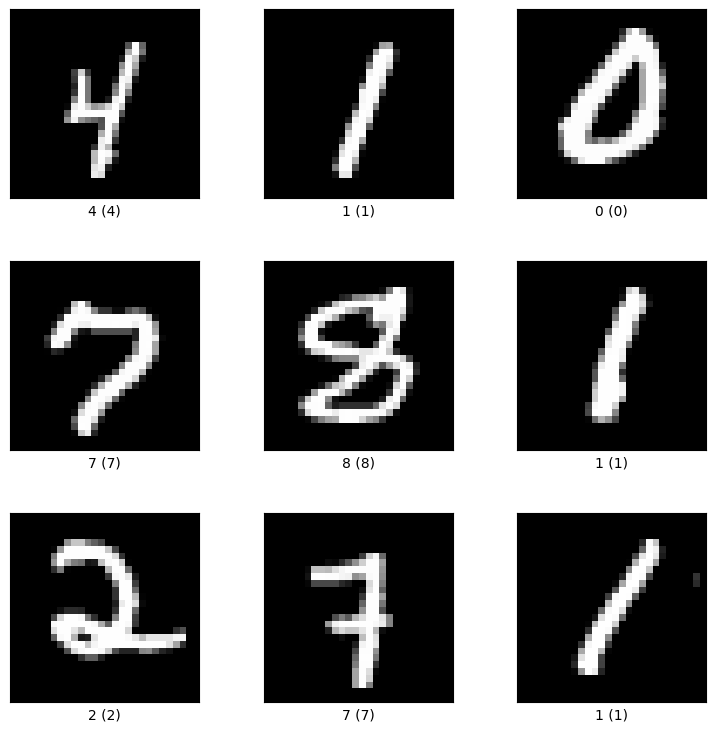

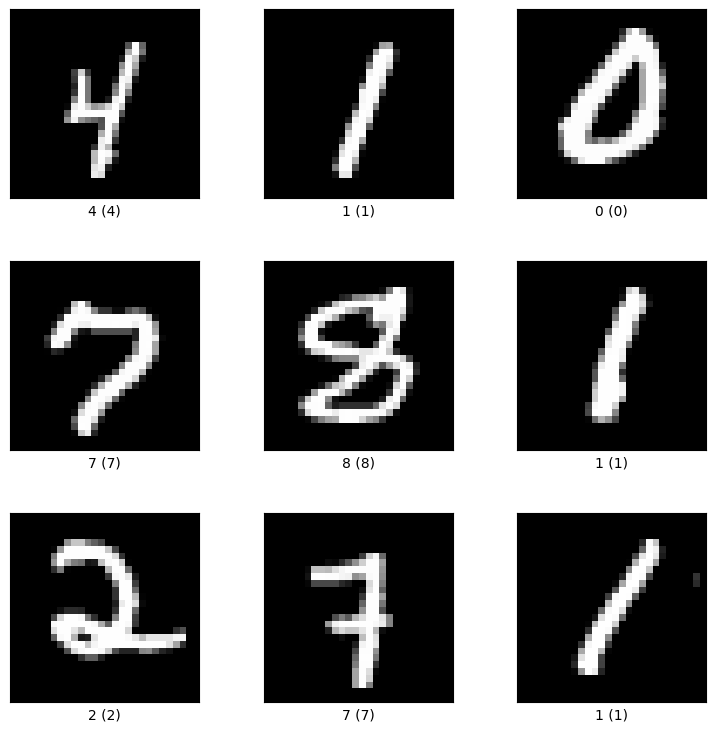

In [11]:
tfds.show_examples(train_ds, ds_info)

In [83]:
def dataset(ds):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y))
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y))
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10)))
    ds = ds.shuffle(10000).batch(512)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

ds = dataset(train_ds)
for elem in ds.take(1):
    print(elem)

(<tf.Tensor: shape=(512, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(512, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>)


In [84]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

In [85]:
def training_loop(model, train, test, loss, opt, epochs=100):
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in range(epochs):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
            #metrics['train_loss'].append(train_loss(loss_value).numpy())
            #metrics['train_accuracy'].append(train_accuracy(y, y_pred).numpy())
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)
            #metrics['test_loss'].append(test_loss(loss_value).numpy())
            #metrics['test_accuracy'].append(test_accuracy(y, y_pred).numpy())

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())
        
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Loss: {metrics["train_loss"][-1]:.4f} Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f} Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()
    
    return metrics


In [86]:
model = Model()
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

In [87]:
metrics = training_loop(model, dataset(train_ds), dataset(test_ds), loss, opt, 10)

Epoch 1/10
Loss: 0.8401 Accuracy: 0.7377
Test Loss: 0.4938 Test Accuracy: 0.8282

Epoch 2/10
Loss: 0.5933 Accuracy: 0.8169
Test Loss: 0.4446 Test Accuracy: 0.8498

Epoch 3/10
Loss: 0.4893 Accuracy: 0.8505
Test Loss: 0.3824 Test Accuracy: 0.8742

Epoch 4/10
Loss: 0.4282 Accuracy: 0.8701
Test Loss: 0.3452 Test Accuracy: 0.8880

Epoch 5/10
Loss: 0.3861 Accuracy: 0.8834
Test Loss: 0.3198 Test Accuracy: 0.8977

Epoch 6/10
Loss: 0.3544 Accuracy: 0.8935
Test Loss: 0.2970 Test Accuracy: 0.9058

Epoch 7/10
Loss: 0.3295 Accuracy: 0.9014
Test Loss: 0.2821 Test Accuracy: 0.9109

Epoch 8/10
Loss: 0.3090 Accuracy: 0.9077
Test Loss: 0.2672 Test Accuracy: 0.9159

Epoch 9/10
Loss: 0.2920 Accuracy: 0.9130
Test Loss: 0.2573 Test Accuracy: 0.9192

Epoch 10/10
Loss: 0.2774 Accuracy: 0.9175
Test Loss: 0.2480 Test Accuracy: 0.9221



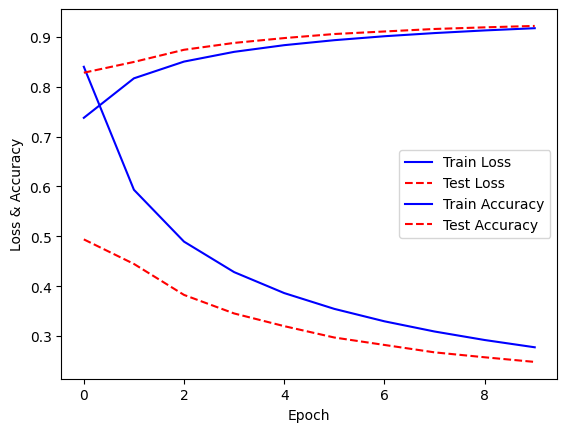

In [88]:
import matplotlib.pyplot as plt
def visualize(metrics):
    plt.figure()

    line1, = plt.plot(metrics['train_loss'], 'b-')
    line2, = plt.plot(metrics['test_loss'], 'r--')
    line3, = plt.plot(metrics['train_accuracy'], 'b-')
    line4, = plt.plot(metrics['test_accuracy'], 'r--')

    plt.legend([line1, line2, line3, line4], ['Train Loss', 'Test Loss', 'Train Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss & Accuracy')

    plt.show()
    

visualize(metrics)

### Hyperparameters

In [89]:
class ModelHyper(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        #self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        #self.dense3 = tf.keras.layers.Dense(10, activation='softmax')
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    

model = Model()
loss = tf.keras.losses.CategoricalCrossentropy()
epochs = 20
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-2, epochs, 1e-4, 2)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

metrics = training_loop(model, dataset(train_ds), dataset(test_ds), loss, opt, epochs)

visualize(metrics)

Epoch 1/15
Loss: 0.6175 Accuracy: 0.8181
Test Loss: 0.3162 Test Accuracy: 0.9107

Epoch 2/15
Loss: 0.4550 Accuracy: 0.8667
Test Loss: 0.2839 Test Accuracy: 0.9200

Epoch 3/15
Loss: 0.3820 Accuracy: 0.8885
Test Loss: 0.2580 Test Accuracy: 0.9265

Epoch 4/15
Loss: 0.3354 Accuracy: 0.9023
Test Loss: 0.2387 Test Accuracy: 0.9319

Epoch 5/15
Loss: 0.3024 Accuracy: 0.9120
Test Loss: 0.2239 Test Accuracy: 0.9360

Epoch 6/15
Loss: 0.2768 Accuracy: 0.9196
Test Loss: 0.2107 Test Accuracy: 0.9397

Epoch 7/15
Loss: 0.2563 Accuracy: 0.9256
Test Loss: 0.2006 Test Accuracy: 0.9422

Epoch 8/15
Loss: 0.2393 Accuracy: 0.9305
Test Loss: 0.1904 Test Accuracy: 0.9451

Epoch 9/15
Loss: 0.2246 Accuracy: 0.9348
Test Loss: 0.1820 Test Accuracy: 0.9474

Epoch 10/15
Loss: 0.2119 Accuracy: 0.9384
Test Loss: 0.1751 Test Accuracy: 0.9495

Epoch 11/15
Loss: 0.2009 Accuracy: 0.9417
Test Loss: 0.1691 Test Accuracy: 0.9512

Epoch 12/15
Loss: 0.1914 Accuracy: 0.9444
Test Loss: 0.1632 Test Accuracy: 0.9529

Epoch 13/15
L